<a href="https://colab.research.google.com/github/hongik-machine/Default-Risk-Scoring/blob/feat%2Fnueral-network/Data-Cleaning/Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필수/옵션 하이브러리 설치
!pip -q install imbalanced-learn

import os, io, sys, json, math, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

In [ ]:
# Colab 파일 업로드 위젯 열기
from google.colab import files

print("'UCI_Credit_Card.csv' 파일을 업로드하세요.")
uploaded = files.upload()  # 파일 선택창

# 파일명 감지
if len(uploaded) == 0:
    raise RuntimeError("업로드된 파일이 없습니다. 다시 실행하고 csv를 선택하세요.")

csv_name = list(uploaded.keys())[0]
print(f"📄 업로드된 파일명: {csv_name}")

# 로딩 + 기본 컬럼명 보정(PAY_0→PAY_1, 타깃명 정리)
try:
    df = pd.read_csv(io.BytesIO(uploaded[csv_name]))
except Exception as e:
    raise RuntimeError(f"CSV 로딩 실패: {e}")

# 원본 컬럼 출력
print("\n 원본 컬럼(상위 15개):")
print(list(df.columns)[:15])

# 타깃/지연 컬럼 rename (원본에 맞춰 유연 처리)
rename_map = {}
if "default.payment.next.month" in df.columns:
    rename_map["default.payment.next.month"] = "target"
if "PAY_0" in df.columns:
    rename_map["PAY_0"] = "PAY_1"

df = df.rename(columns=rename_map)

# 최소 필요 컬럼 검증
required_cols = {"LIMIT_BAL","SEX","EDUCATION","MARRIAGE",
                 "BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6",
                 "PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6",
                 "PAY_1","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6",
                 "target"}
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print("\n 누락 컬럼:", missing)
    raise RuntimeError("필수 컬럼이 없습니다. 업로드한 파일이 올바른지 확인하세요.")

print("\n 로딩 성공! 데이터 shape:", df.shape)
display(df.head())


'UCI_Credit_Card.csv' 파일을 업로드하세요.


Saving UCI_Credit_Card.csv to UCI_Credit_Card.csv
📄 업로드된 파일명: UCI_Credit_Card.csv

 원본 컬럼(상위 15개):
['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']

 로딩 성공! 데이터 shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
# 기본 점검 출력 (타깃 분포/요약)
print(" target 분포(비율):")
print(df["target"].value_counts(normalize=True).round(3))

print("\n LIMIT_BAL 요약:")
print(df["LIMIT_BAL"].describe())

print("\n PAY_1..6 요약:")
print(df[["PAY_1","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]].describe())

 target 분포(비율):
target
0    0.779
1    0.221
Name: proportion, dtype: float64

 LIMIT_BAL 요약:
count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

 PAY_1..6 요약:
              PAY_1         PAY_2         PAY_3         PAY_4         PAY_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1.123802      1.197186      1.196868      1.169139      1.133187   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000  

In [ ]:
# 범주형 이상값 제거 (EDUCATION, MARRAGING) + 제거 통계 출력

# 제거 전 분포 출력
print("EDUCATION 분포(제거 전):")
print(df["EDUCATION"].value_counts().sort_index())
print("\nMARRIAGE 분포(제거 전):")
print(df["MARRIAGE"].value_counts().sort_index())

before = len(df)
mask_ok = (~df["EDUCATION"].isin({0,5,6})) & (~df["MARRIAGE"].isin({0}))
df = df.loc[mask_ok].reset_index(drop=True)
removed = before - len(df)

print(f"\n 제거된 행 수: {removed} (전체 대비 {removed/before:.3%})")

# 제거 후 분포 출력
print("\n EDUCATION 분포(제거 후):")
print(df["EDUCATION"].value_counts().sort_index())
print("\n MARRIAGE 분포(제거 후):")
print(df["MARRIAGE"].value_counts().sort_index())


EDUCATION 분포(제거 전):
EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64

MARRIAGE 분포(제거 전):
MARRIAGE
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64

 제거된 행 수: 399 (전체 대비 1.330%)

 EDUCATION 분포(제거 후):
EDUCATION
1    10581
2    14024
3     4873
4      123
Name: count, dtype: int64

 MARRIAGE 분포(제거 후):
MARRIAGE
1    13477
2    15806
3      318
Name: count, dtype: int64


In [ ]:
# PAY_n 보정 (+1 시프트, (-1,0)→0로 그룹)

pay_cols = [f"PAY_{i}" for i in range(1,7)]

def fix_pay_col(s: pd.Series) -> pd.Series:
    # +1 시프트 후, 0 이하를 0으로 클리핑
    t = s + 1
    t = t.where(t > 0, 0)
    return t

print("PAY 컬럼 변환 전 값 분포 예시(PAY_1 상위값):")
print(df["PAY_1"].value_counts().sort_index().head(15))

df[pay_cols] = df[pay_cols].apply(fix_pay_col)

print("\n PAY 변환 후 요약:")
print(df[pay_cols].describe())


🔧 PAY 컬럼 변환 전 값 분포 예시(PAY_1 상위값):
PAY_1
-2     2708
-1     5633
 0    14499
 1     3662
 2     2640
 3      320
 4       76
 5       24
 6       11
 7        9
 8       19
Name: count, dtype: int64

 PAY 변환 후 요약:
              PAY_1         PAY_2         PAY_3         PAY_4         PAY_5  \
count  29601.000000  29601.000000  29601.000000  29601.000000  29601.000000   
mean       1.076551      0.994426      0.972602      0.926523      0.887335   
std        0.992174      1.038809      1.028262      0.990891      0.945531   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      1.000000      1.000000      1.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max        9.000000      9.000000      9.000000      9.000000      9.000000   

              PAY_6  
count  29601.000000  
mean       0.874802  
std      

In [ ]:
# 업로드/클리닝 중 오류 대비

# 결측치 유무, dtype 체크
print("결측치 수(상위 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

print("\ndtypes(상위 15):")
print(df.dtypes.head(15))

# 샘플 레코드 3개
print("\n샘플 레코드 3개:")
display(df.sample(3, random_state=42))


결측치 수(상위 10):
ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
dtype: int64

dtypes(상위 15):
ID             int64
LIMIT_BAL    float64
SEX            int64
EDUCATION      int64
MARRIAGE       int64
AGE            int64
PAY_1          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
dtype: object

샘플 레코드 3개:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
4203,4239,70000.0,2,2,1,29,1,1,1,1,...,4038.0,4123.0,4264.0,1054.0,1066.0,144.0,150.0,210.0,500.0,0
9172,9264,110000.0,1,2,1,30,1,1,0,3,...,59308.0,60576.0,42784.0,1500.0,63853.0,1500.0,2062.0,0.0,7222.0,0
25044,25370,210000.0,2,1,2,27,0,1,1,1,...,38986.0,689.0,2040.0,2000.0,1985.0,1300.0,0.0,2040.0,4081.0,0


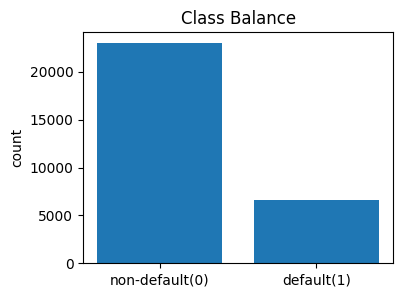

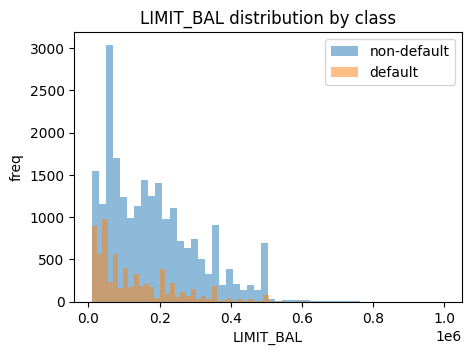

In [ ]:
# 그래프 1: 클래스 불균형, LIMIT_BAL 분포(기본 히스토그램)

# 클래스 불균형 막대
counts = df["target"].value_counts().sort_index()
fig = plt.figure(figsize=(4,3))
plt.bar(["non-default(0)","default(1)"], [counts.get(0,0), counts.get(1,0)])
plt.title("Class Balance")
plt.ylabel("count")
plt.show()

# LIMIT_BAL 히스토그램(두 클래스 비교)
bins = 50
fig = plt.figure(figsize=(5,3.5))
plt.hist(df.loc[df["target"]==0, "LIMIT_BAL"], bins=bins, alpha=0.5, label="non-default")
plt.hist(df.loc[df["target"]==1, "LIMIT_BAL"], bins=bins, alpha=0.5, label="default")
plt.xlabel("LIMIT_BAL")
plt.ylabel("freq")
plt.title("LIMIT_BAL distribution by class")
plt.legend()
plt.show()

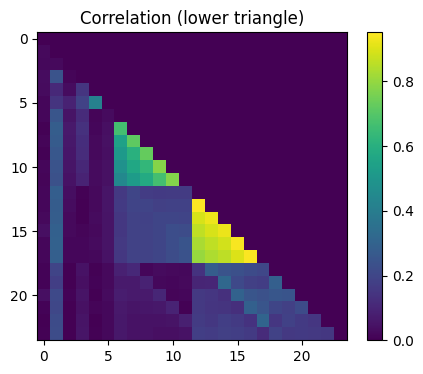

 고상관(≥0.92) 드롭 대상:
['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
 shape(before → after): (29601, 25) → (29601, 20)


In [ ]:
# 상관행렬(피어슨) + 고상관(≥0.92) 컬럼 드롭

numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "target"]

corr = df[numeric_cols].corr(method="pearson").abs()

# 하삼각만 시각화(간단 imshow)
fig = plt.figure(figsize=(5,4))
mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)
mat = np.where(mask, corr.values, np.nan)
plt.imshow(np.nan_to_num(mat), aspect='auto')
plt.title("Correlation (lower triangle)")
plt.colorbar()
plt.show()

# 고상관 드롭 후보
to_drop = set()
cols = corr.columns
for i in range(len(cols)):
    for j in range(i):
        if corr.iloc[i,j] >= 0.92:
            to_drop.add(cols[i])

print(" 고상관(≥0.92) 드롭 대상:")
print(sorted(to_drop))

df_clean = df.drop(columns=list(to_drop))
print(" shape(before → after):", df.shape, "→", df_clean.shape)


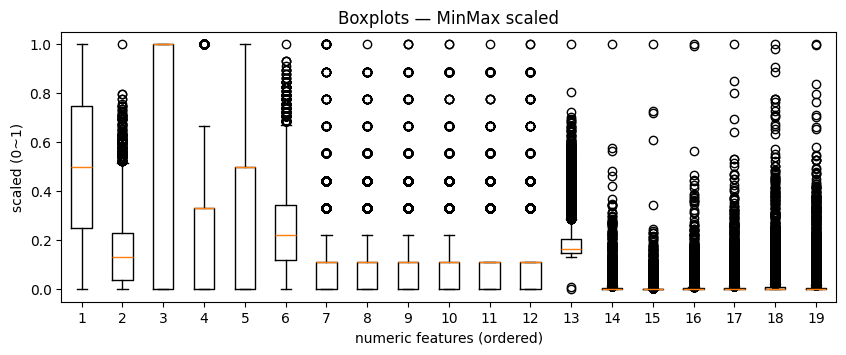

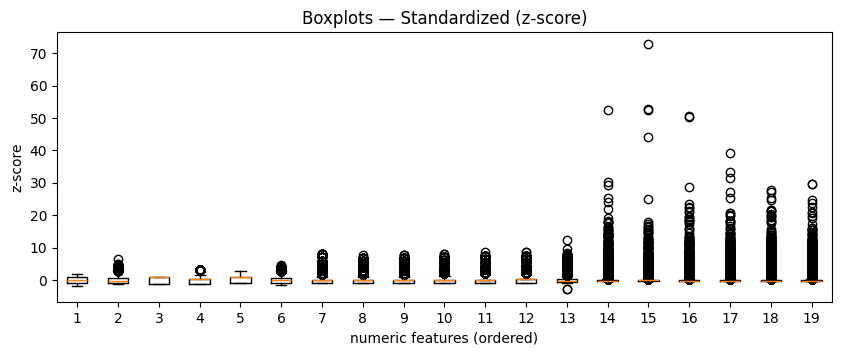

In [ ]:
# 그래프 2: MinMax/Standard 스케일 박스플롯으로 이상치 시각 점검

num_clean = [c for c in df_clean.select_dtypes(include=["number"]).columns if c != "target"]

# MinMax
mm = MinMaxScaler()
X_mm = mm.fit_transform(df_clean[num_clean])

fig = plt.figure(figsize=(10,3.5))
plt.boxplot(X_mm, showfliers=True)
plt.title("Boxplots — MinMax scaled")
plt.xlabel("numeric features (ordered)")
plt.ylabel("scaled (0~1)")
plt.show()

# Standard
ss = StandardScaler()
X_ss = ss.fit_transform(df_clean[num_clean])

fig = plt.figure(figsize=(10,3.5))
plt.boxplot(X_ss, showfliers=True)
plt.title("Boxplots — Standardized (z-score)")
plt.xlabel("numeric features (ordered)")
plt.ylabel("z-score")
plt.show()

In [ ]:
# 최종 확인 출력

out_csv = "uci_credit_clean.csv"
df_clean.to_csv(out_csv, index=False)
print(f" 저장 완료: {out_csv}")
print("최종 컬럼(상위 20):", list(df_clean.columns)[:20], f"... 총 {len(df_clean.columns)}개")
print("최종 행 수:", len(df_clean))

# 최종 target 분포 유지 확인
print("\n 최종 target 분포(비율):")
print(df_clean["target"].value_counts(normalize=True).round(3))


 저장 완료: uci_credit_clean.csv
최종 컬럼(상위 20): ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'target'] ... 총 20개
최종 행 수: 29601

 최종 target 분포(비율):
target
0    0.777
1    0.223
Name: proportion, dtype: float64
